In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 13, 'ytick.labelsize': 13,
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 1200,
})

import numpy as np

from boxforage.utils import plot_single_box_episode, plot_multi_box_episode

# Single box foraging example

## Training progress of the agent

Agent was trained for 30 epochs.


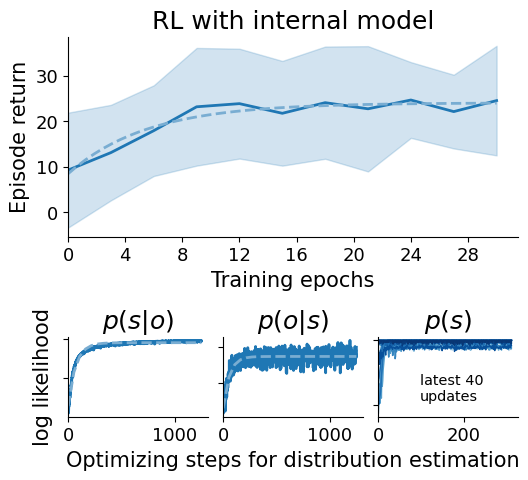

In [2]:
from irc.manager import IRCManager

manager = IRCManager(device='cpu', defaults='defaults/single_box.yaml')
agent, fig = manager.inspect_agent(env_param=[0.2, 0.9, 10], seed=0)
# agent, fig = manager.inspect_agent(env_param=[0.2, 0.9, 10], seed=1)

## Example episode of the trained agent

In [3]:
episode = agent.run_one_episode(num_steps=60)

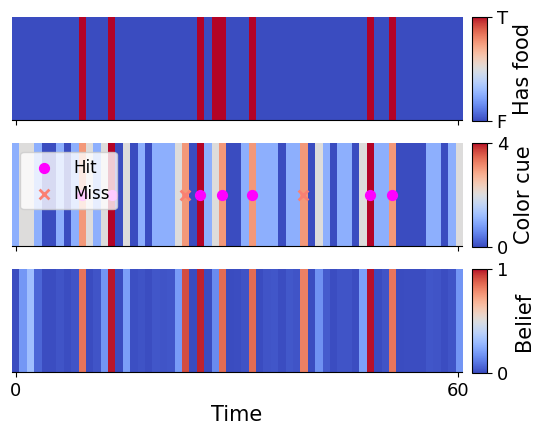

In [4]:
fig = plot_single_box_episode(episode)

# Two boxes foraging example

## Training progress of the agent
The agent assumes identical parameters for each box, e.g. $p_\mathrm{appear}$, $p_\mathrm{vanish}$, $p_\mathrm{true}$, $p_\mathrm{false}$ ...

Agent was trained for 10 epochs.


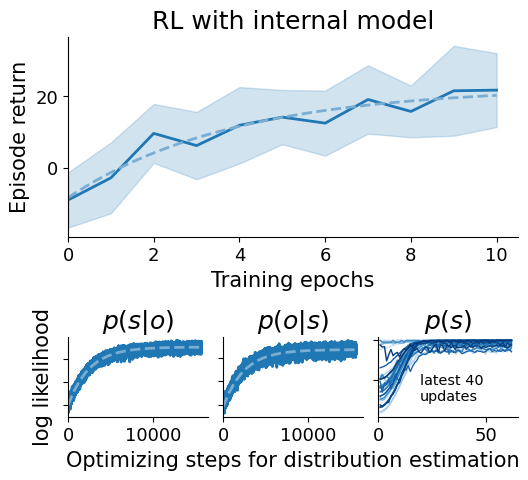

In [5]:
from irc.manager import IRCManager

manager = IRCManager(device='cpu', defaults='defaults/identical_box.yaml')
# manager.defaults.agent.model.estimate.p_s.num_epochs = 10
# manager.defaults.agent.model.estimate.p_s_o.num_samples = 5000
# manager.defaults.agent.model.estimate.p_o_s.num_samples = 5000
agent, fig = manager.inspect_agent(env_param=[0.2, 0.05, 0.8, 0.2, 10.0, -1.0, -0.5], seed=0)

## Example episode of the trained agent

In [6]:
episode = agent.run_one_episode(num_steps=60)

# from boxforage.multi_box import MultiBoxForaging

# env = MultiBoxForaging(spec={'boxes': {'p_true': 0.6, 'p_false': 0.4}})
# episode = agent.run_one_episode(env=env, num_steps=60)

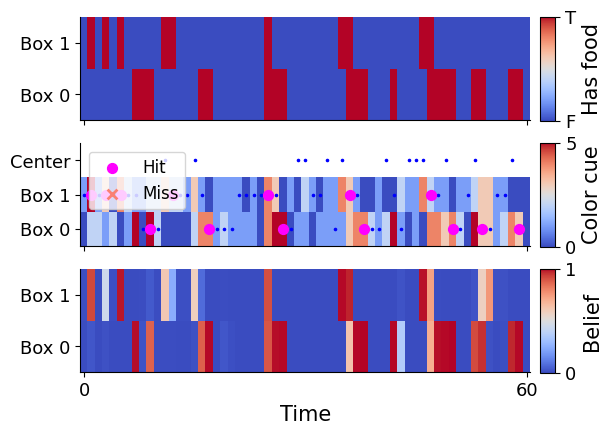

In [7]:
fig = plot_multi_box_episode(episode)